In [1]:
import cv2
from matplotlib import pyplot as plt
import os
import csv
import pandas as pd
import numpy as np
import cv2
from skimage import data, util
from skimage.measure import label, regionprops
from skimage import morphology

In [2]:
##### upload lookup table for score ######
# lookup_table_fn = "lookup_table_builtin.npy"
lookup_table_fn = "lookup_table_12_components.npy"

lookup_table = np.load(lookup_table_fn)

#### lookup functions #####
# Convert HSV values to 5-bit equivalents
def hsv_to_5bit(h, s, v):
    h_5bit = int((h / 180.0) * 63)  # Hue range of 0-180
    s_5bit = int((s / 255.0) * 63)  # Saturation range of 0-255
    v_5bit = int((v / 255.0) * 63)  # Value range of 0-255
    return h_5bit, s_5bit, v_5bit

# Function to query the lookup table with HSV values
def query_lookup_table(h, s, v, lookup_table):
    h_5bit, s_5bit, v_5bit = hsv_to_5bit(h, s, v)
    return lookup_table[h_5bit, s_5bit, v_5bit]

In [3]:
filenames_list = []
images_bgr = []
images_hsv = []


for filename in os.listdir('ECE5242Proj1-test'):
    filenames_list.append(filename)
    if filename.endswith(".png"):
        img_path = os.path.join('ECE5242Proj1-test', filename)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read {img_path}")
        
        imghsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
        # imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # images_rgb.append(imgrgb)
        images_bgr.append(img)
        images_hsv.append(imghsv)
        print(f"Loaded {filename}")
    # break # comment out line if testing more than one image

Loaded test_3.png
Loaded test_2.png
Loaded test_1.png
Loaded test_5.png
Loaded test_4.png


In [4]:
print(len(images_bgr))
print(len(images_hsv))

5
5


(array([2.60398e+05, 4.80000e+02, 2.96000e+02, 1.98000e+02, 1.48000e+02,
        9.70000e+01, 6.40000e+01, 5.70000e+01, 4.10000e+01, 4.20000e+01,
        2.50000e+01, 1.90000e+01, 1.20000e+01, 2.20000e+01, 1.70000e+01,
        1.00000e+01, 1.20000e+01, 1.20000e+01, 1.30000e+01, 1.00000e+01,
        4.00000e+00, 4.00000e+00, 4.00000e+00, 2.00000e+00, 1.00000e+01,
        5.00000e+00, 7.00000e+00, 7.00000e+00, 4.00000e+00, 2.00000e+00,
        4.00000e+00, 4.00000e+00, 2.00000e+00, 2.00000e+00, 3.00000e+00,
        5.00000e+00, 4.00000e+00, 1.00000e+00, 9.00000e+00, 3.00000e+00,
        4.00000e+00, 4.00000e+00, 4.00000e+00, 0.00000e+00, 1.00000e+00,
        5.00000e+00, 5.00000e+00, 4.00000e+00, 2.00000e+00, 5.00000e+00,
        1.00000e+00, 4.00000e+00, 3.00000e+00, 0.00000e+00, 2.00000e+00,
        1.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00, 2.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00

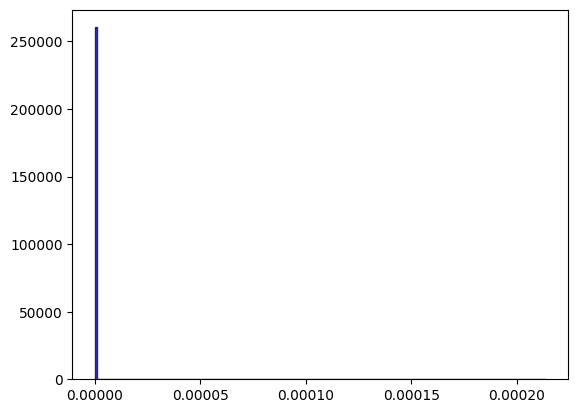

In [4]:
flat_lt = lookup_table.flatten()
# Plotting the histogram
plt.hist(flat_lt, bins=180, alpha=0.75, color='blue', edgecolor='black')

In [4]:
##### creating a mask #######
segmented_images = []
masks = []

for a, imghsv in enumerate(images_hsv):
    mask = np.zeros(imghsv.shape[:2], dtype=np.uint8)

    ####### DEFINE THRESHOLD HERE #########
    threshold = 10 ** -6.5

    # Apply your function and create the mask
    for i in range(imghsv.shape[0]):
        for j in range(imghsv.shape[1]):
            h, s, v = imghsv[i, j]
            if query_lookup_table(h, s, v, lookup_table) > threshold:
                mask[i, j] = 255  # Set to 255 where the condition is met
    

    overlay_color = [0, 255, 0]  # Green

    # convert the mask to a 3-channel image
    mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    mask_colored[mask == 255] = overlay_color  # Apply the overlay color
    masks.append(mask_colored)
    cv2.imshow('Mask Image', mask_colored)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # combine with corresponding rgb image
    segmented_colored_img = cv2.addWeighted(images_bgr[a], 1, mask_colored, 0.5, 0)
    segmented_images.append(segmented_colored_img)

    cv2.imshow('Segmented Image', segmented_colored_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    print("finished iteration")



finished iteration
finished iteration
finished iteration
finished iteration
finished iteration


In [5]:
## aspect ratio function for later
def aspect_ratio(region):
    """calculate the height/width of the region"""
    minr, minc, maxr, maxc = region.bbox
    height = maxr - minr
    width = maxc - minc
    return height / width if width > 0 else 0

In [6]:
# filtering noise and other objects to prepare for bounding box

CHECK_RATIO = False # whether we want to check aspect ratio 
distances = [10, 15, 5, 12, 20]

for a, mask in enumerate(masks):

    label_img = label(mask, connectivity=2)

    regions = regionprops(label_img)

    # filtering
    min_area = 100  # Minimum pixel bound
    big_regions = [region for region in regions if min_area < region.area]

    # Create a mask for the filtered regions
    filtered_mask = np.zeros_like(mask, dtype=np.uint8)
    for region in big_regions:
        print(f"Region {region.label}: Area {region.area}")
        for coord in region.coords:
            # fill
            filtered_mask[coord[0], coord[1]] = 255

    cv2.imshow('Filtered Mask Image', filtered_mask)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    if filtered_mask.ndim > 2:
        # need to lower dimensions of filtered mask
        filtered_mask = filtered_mask[:, :, 0] 

    # Option 1: dilation then erosion
    rad = morphology.disk(3) 
    dilated_mask_1 = morphology.dilation(filtered_mask, rad)
    eroded_mask_1 = morphology.erosion(dilated_mask_1, rad)

    cv2.imshow('Option 1: dilation then erosion', eroded_mask_1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # # Option 2: erosion then dilation ###### CONCLUSION: BAD ############
    # rad = morphology.disk(3) 
    # eroded_mask_2 = morphology.erosion(filtered_mask, rad)
    # dilated_mask_2 = morphology.dilation(eroded_mask_2, rad)

    # cv2.imshow('Option 2: erosion then dilation', dilated_mask_2)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    #### If multiple regions left, then pick the one shaped most like an upright triangle ####
    if CHECK_RATIO:
        label_mask = label(eroded_mask_1)
        rp_mask = regionprops(label_mask)
        if len(rp_mask) > 1:
            # Find the region with the aspect ratio closest to upright triangle
            # Pick best if only looking for one, otherwise pick all that are within range
            best_regions = []
            best_aspect_ratio_diff = float('inf')  # Initialize with infinity


            ###### CURRENTLY ONLY PICKING BEST ONE ########
            for region in rp_mask:
                
                curr_aspect_ratio = aspect_ratio(region)
                print("aspect ratio: ", curr_aspect_ratio)
                if 1.4 <= curr_aspect_ratio <= 2.6:
                    best_regions.append(region)
                    # aspect_ratio_diff = abs(curr_aspect_ratio - 2)
                    # if aspect_ratio_diff < best_aspect_ratio_diff:
                    #     best_aspect_ratio_diff = aspect_ratio_diff
                    #     best_regions.append(region)
            
            # Create a mask for the best matching region
            final_mask = np.zeros_like(eroded_mask_1, dtype=np.uint8)
            for best_region in best_regions:
                for coord in best_region.coords:
                    final_mask[coord[0], coord[1]] = 255
        
        else:
            final_mask = eroded_mask_1
    else:
        final_mask = eroded_mask_1
    
    ##### make bounding boxes for each remaining region, AND estimate the distance ####
    # first combining final_mask with bgr image
    overlay_color = [255, 0, 0]  # Blue?
    mask_colored = cv2.cvtColor(final_mask, cv2.COLOR_GRAY2RGB)
    mask_colored[final_mask == 255] = overlay_color
    final_image_unbounded = cv2.addWeighted(images_bgr[a], 1, mask_colored, 0.5, 0)
    
    label_final = label(final_mask)
    for region in regionprops(label_final):
        
        min_row, min_col, max_row, max_col = region.bbox
        # drawing bounding box
        cv2.rectangle(final_image_unbounded, (min_col, min_row), (max_col, max_row), (0, 255, 0), 2)

        ###### REPORT MEASURING TO THE BOTTOM CENTER ########
        bottom_center = ((min_col + max_col) // 2, max_row)

        point_location = bottom_center  # Coordinates in the format (x, y)
        point_color = (0, 0, 255)  # Red color in BGR format
        point_radius = 3  # Small radius for the point
        point_thickness = -1
        cv2.circle(final_image_unbounded, point_location, point_radius, point_color, point_thickness)

        ###### CALCULATE DISTANCE OF CONE ####### TODO
        height = max_row - min_row
        width = max_col - min_col
        print("height: ", height)
        print("width: ", width)

        # ##### for testing
        dist_inches = 17 * 650 / height
        dist_ft = dist_inches / 12.0

        ### for training
        # dist_train = distances[a] * 12
        # est_focal_len = dist_train * height / 17

        print(f"Image {a} cone bottom-center and distance: {bottom_center, dist_ft}")
    
    cv2.imshow('Segmented Image with Bounding Boxes', final_image_unbounded)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    

Region 1: Area 3232.0
height:  116
width:  47
Image 0 cone bottom-center and distance: ((318, 452), 8.182471264367816)
Region 1: Area 13785.0
height:  231
width:  108
Image 1 cone bottom-center and distance: ((474, 536), 4.108946608946609)
Region 1: Area 2378.0
height:  179
width:  36
Image 2 cone bottom-center and distance: ((228, 522), 5.302607076350093)
Region 1: Area 21907.0
Region 2: Area 3793.0
height:  298
width:  136
Image 3 cone bottom-center and distance: ((346, 601), 3.1851230425055927)
height:  129
width:  52
Image 3 cone bottom-center and distance: ((264, 453), 7.357881136950905)
Region 9: Area 459.0
height:  45
width:  17
Image 4 cone bottom-center and distance: ((300, 419), 21.09259259259259)
